# **Laporan Proyek Machine Learning - Ghifari Adil Ruchiyat**

---
# **1. Import library**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns
%matplotlib inline

from imblearn.over_sampling import SMOTE
from scipy.stats import pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

---
# **2. Data Understanding**

## 2.1 Data loading

In [ ]:
df1 = pd.read_csv('datatraining.txt')
df2 = pd.read_csv('datatest.txt')
df3 = pd.read_csv('datatest2.txt')
df = pd.concat([df1, df2, df3], ignore_index=True)
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51:00,23.180,27.2720,426.00,721.25,0.004793,1
1,2015-02-04 17:51:59,23.150,27.2675,429.50,714.00,0.004783,1
2,2015-02-04 17:53:00,23.150,27.2450,426.00,713.50,0.004779,1
3,2015-02-04 17:54:00,23.150,27.2000,426.00,708.25,0.004772,1
4,2015-02-04 17:55:00,23.100,27.2000,426.00,704.50,0.004757,1
...,...,...,...,...,...,...,...
20555,2015-02-18 09:15:00,20.815,27.7175,429.75,1505.25,0.004213,1
20556,2015-02-18 09:16:00,20.865,27.7450,423.50,1514.50,0.004230,1
20557,2015-02-18 09:16:59,20.890,27.7450,423.50,1521.50,0.004237,1
20558,2015-02-18 09:17:59,20.890,28.0225,418.75,1632.00,0.004279,1


## 2.2 Cek missing value

In [ ]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

## 2.3 Menampilkan informasi data

In [ ]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


## 2.4 Visualisasi Data

### 2.4.1 Plot kelas

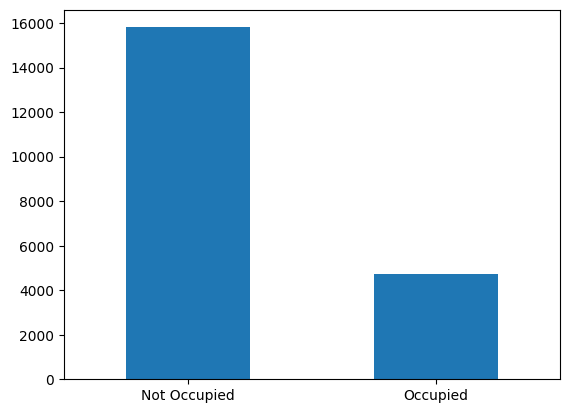

In [ ]:
fig, ax = plt.subplots()
df['Occupancy'].value_counts().plot(kind='bar')
ax.set_xticklabels(['Not Occupied', 'Occupied'], rotation=0)
plt.show()

### 2.4.2 Histogram feature numerik

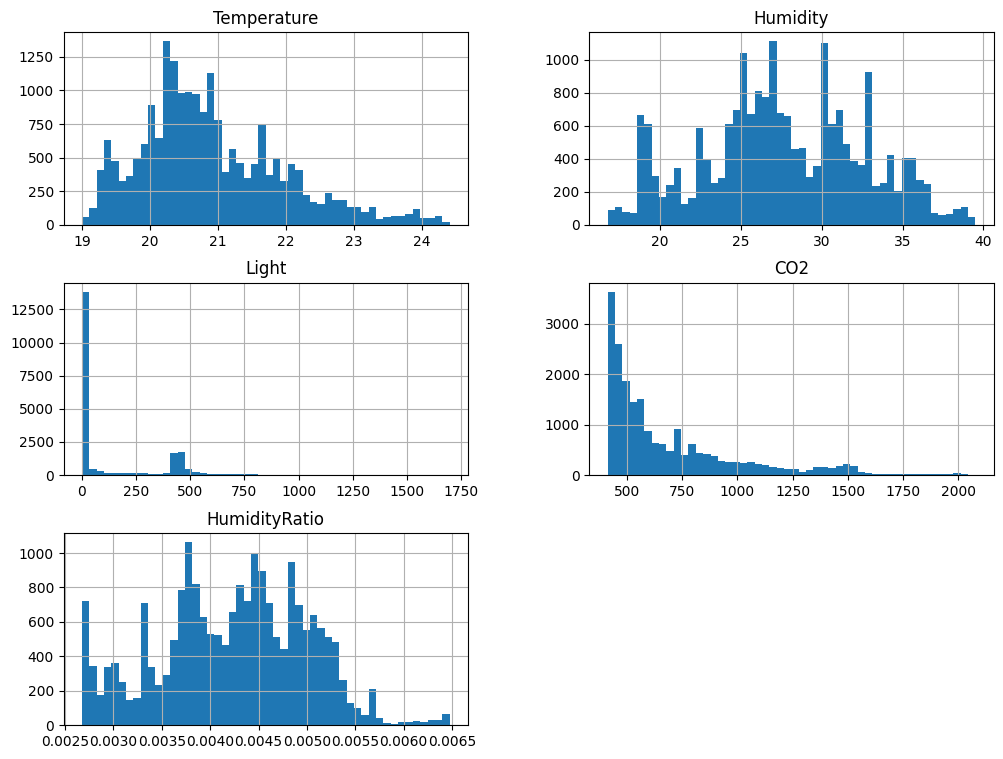

In [ ]:
dfNumeric = df.drop(columns=['Occupancy', 'date'])
dfNumeric.hist(bins=50, figsize=(12,9))
plt.show()

### 2.4.3 Grafik Histogram masing-masing kelas

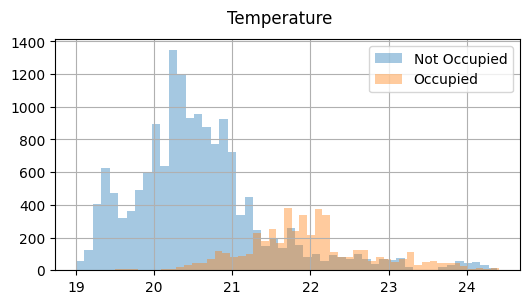

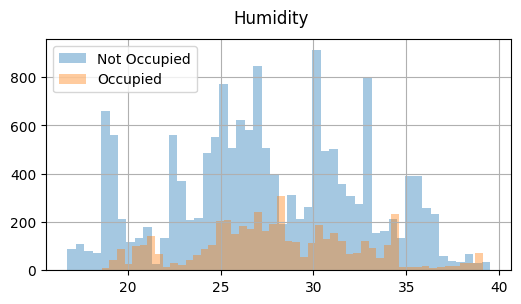

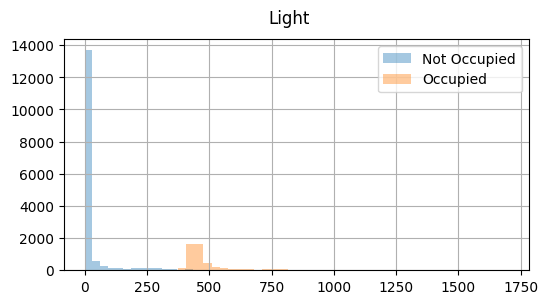

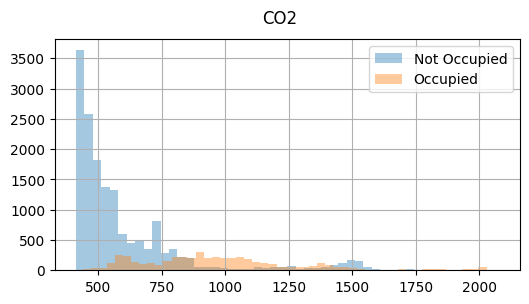

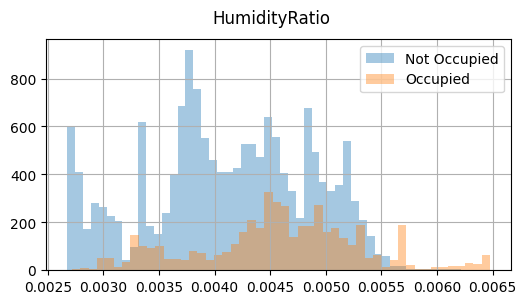

In [ ]:
for column in dfNumeric.columns:
    fig, ax = plt.subplots(figsize=(6,3))
    fig.suptitle(column)
    df.groupby("Occupancy")[column].hist(alpha=0.4, bins=50, legend=True)
    plt.legend(['Not Occupied', 'Occupied'])

### 2.4.4 Box Plot masing-masing kelas

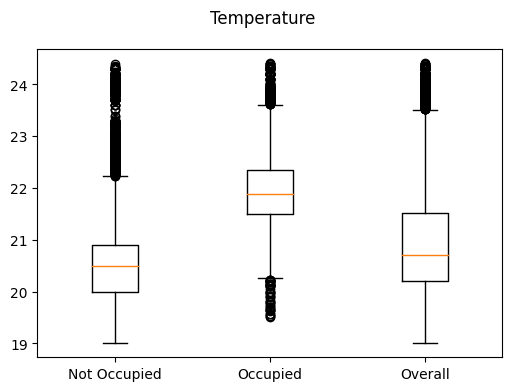

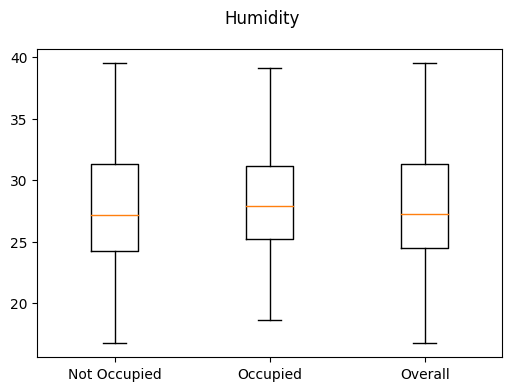

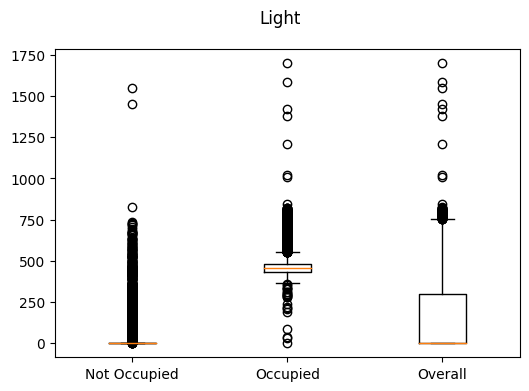

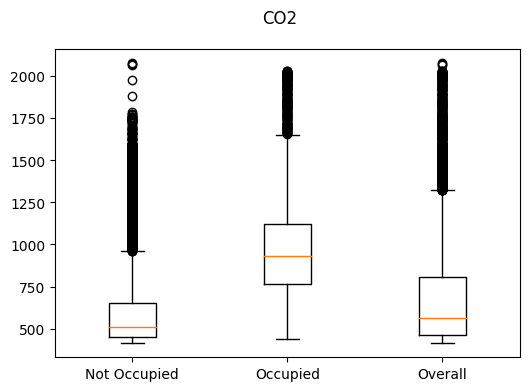

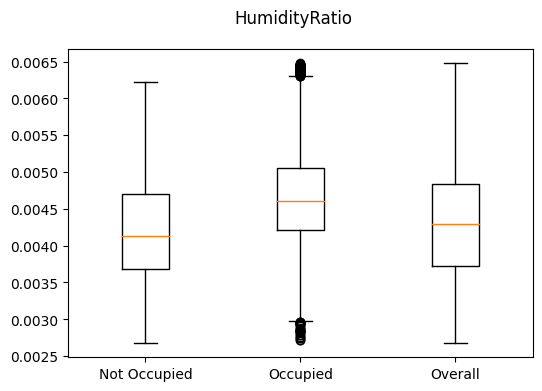

In [ ]:
for column in dfNumeric:
  fig, ax = plt.subplots(figsize=(6,4))
  fig.suptitle(column)
  ax.boxplot([df[column][df['Occupancy']==0], df[column][df['Occupancy']==1], df[column]])
  ax.set_xticklabels(['Not Occupied', 'Occupied', 'Overall'])

### 2.4.5 Correlation matrix

#### Menghitung Correlation Matrix dengan metode Cramer's V

<ipython-input-9-cd46de278163>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr().round(2)


Text(0.5, 1.0, 'Correlation Matrix')

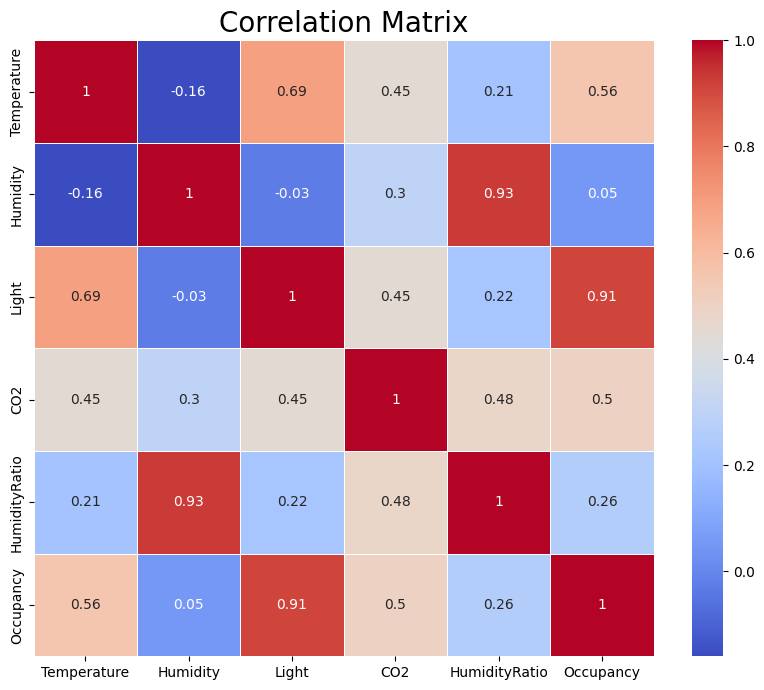

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr().round(2)

sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix", size=20)

---
# **3. Data Preparation**

## 3.1 Drop column Date, HumidityRatio, dan Humidity

In [ ]:
dfTrain = df1.drop(columns=['date', 'HumidityRatio', 'Humidity'])

## 3.2 Melakukan normalisasi

In [ ]:
xTrain = dfTrain.drop(columns=('Occupancy'))
yTrain = dfTrain.Occupancy
xColumns = xTrain.columns

scaler = StandardScaler().fit(xTrain)
xTrain = scaler.transform(xTrain)

## 3.3 Oversampling dengan metode SMOTE

In [ ]:
smote = SMOTE(random_state=1)
xTrain, yTrain = smote.fit_resample(xTrain, yTrain)

---
# **4. Modelling**

## 4.1 Membuat Model Baseline

In [ ]:
baselineModel = RandomForestClassifier(random_state=1)

## 4.2 Melatih Model Baseline

In [ ]:
baselineModel.fit(xTrain, yTrain)

RandomForestClassifier(random_state=1)

## 4.3 Menginisiasi Random Search

In [ ]:
paramRanges = {
    'n_estimators': range(25, 501),
    'max_depth': [None] + list(range(3,21)),
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': range(2,6)
}

search = RandomizedSearchCV(RandomForestClassifier(random_state=1), paramRanges, random_state=1, n_iter=50)

## 4.4 Melakukan Random Search

In [ ]:
search.fit(xTrain, yTrain)
tunedModel = search.best_estimator_
search.best_params_

{'n_estimators': 166,
 'min_samples_split': 5,
 'max_features': 'log2',
 'max_depth': 5}

## 4.5 Feature Importance

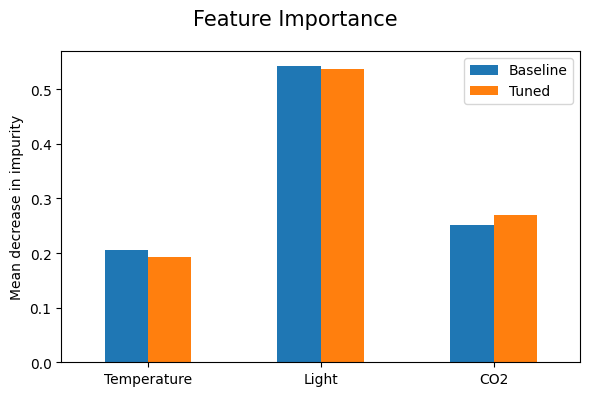

In [ ]:
featureNames = [i for i in xColumns]
baselineImportances = pd.Series(baselineModel.feature_importances_, index=featureNames)
tunedImportances = pd.Series(tunedModel.feature_importances_, index=featureNames)
importances = pd.DataFrame({"Baseline":baselineImportances, "Tuned":tunedImportances})

fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle("Feature Importance", fontsize=15)

importances.plot.bar(rot=0, ax=ax)
ax.set_ylabel("Mean decrease in impurity")

fig.tight_layout()

---
# **5. Evaluasi Model**

## 5.1 Menyiapkan dataset test

In [ ]:
dfTest = pd.concat([df2, df3])
xTest = dfTest.drop(columns=['Occupancy', 'date', 'HumidityRatio', 'Humidity'])
xTest = scaler.transform(xTest)
yTest = dfTest.Occupancy

## 5.2 Menyiapkan Dataframe untuk evaluasi

In [ ]:
dfEval = pd.DataFrame()

models = {'Baseline': baselineModel, 'Tuned': tunedModel}

## 5.3 Menghitung metrik pada masing-masing model

In [ ]:
for name, model in models.items():
    dfEval.loc['Accuracy', name] = accuracy_score(yTest, model.predict(xTest))
    dfEval.loc['F1 Score', name] = f1_score(yTest, model.predict(xTest))
    dfEval.loc['ROC-AUC', name] = roc_auc_score(yTest, model.predict(xTest))

dfEval

,Baseline,Tuned
Accuracy,0.970685,0.988967
F1 Score,0.940328,0.977734
ROC-AUC,0.963449,0.991250


## 5.4 Plot evaluasi model

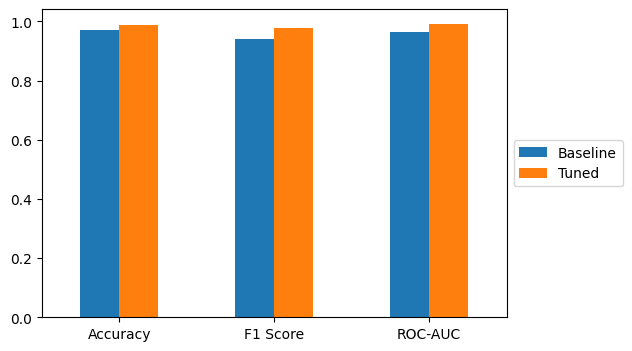

In [ ]:
dfEval.plot(kind='bar', figsize=(6,4), rot=0) \
  .legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

plt.show()

## 5.5 Confusion Matrix pada dataset test

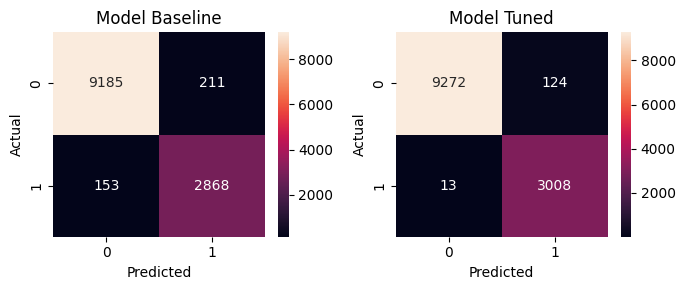

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3))

sns.heatmap(data=confusion_matrix(yTest, baselineModel.predict(xTest)), ax=ax1, annot=True, fmt='d')
ax1.set_title('Model Baseline')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(data=confusion_matrix(yTest, tunedModel.predict(xTest)), ax=ax2, annot=True, fmt='d')
ax2.set_title('Model Tuned')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

fig.tight_layout()
plt.show()